In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as Func


In [2]:
logostxt=open("D:/Downloads/datasets/mini_logo_good/spisok.txt")
logos_list=logostxt.read().split("\n")
#logos_list=['Burger King','KFC','McDonalds','Other','Starbucks','Subway']
logos_list.sort()
CountOfClasses=len(logos_list)
logos_list

['ABLE',
 'AC',
 'ACID',
 'AFernandez',
 'ALCO',
 'AND1',
 'Acorn',
 'AdanyEva',
 'Addidas',
 'Advent',
 'Alliance',
 'AlmostSkateboards',
 'Always',
 'Amador',
 'Amoco',
 'Amsterdam',
 'Anchorage',
 'Animal',
 'Ankara',
 'Annapurna']

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is',device)

device is cpu


In [4]:
path = 'D:/Downloads/datasets/mini_logo_good/train'

In [5]:
transforms=tv.transforms.Compose([
    tv.transforms.Resize((60,60)),
    tv.transforms.ToTensor()
    
])

In [6]:
from matplotlib.transforms import Transform
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)

In [7]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True,num_workers=2)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0

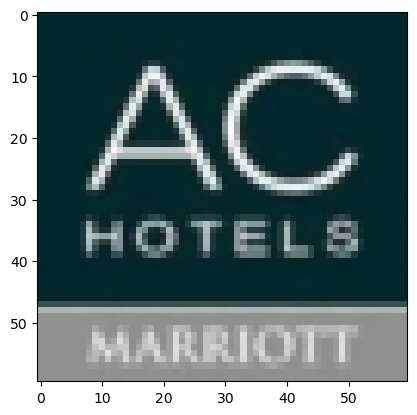

In [8]:
plt.imshow(dataset[118][0].numpy().transpose((1,2,0)))
print(dataset[118])
#print(dataset[50][0].numpy().transpose((1,2,0)).shape)
#print(dataset[50][0].shape)
#m=nn.Conv2d(3,32,kernel_size=3,padding=0)
#m=nn.AdaptiveAvgPool2d((1,1))
#print(m(dataset[50][0]).shape) 
#plt.imshow(m(dataset[50][0]).numpy().transpose((1,2,0)))
#print(dataset[50])

In [9]:
class CNA(nn.Module):
  def __init__(self,in_ch=32,out_ch=32):
    super().__init__()
    self.conv=nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1)
    self.norm=nn.BatchNorm2d(out_ch)
    self.act=nn.ReLU()

  def forward(self,x):
    out=self.conv(x)
    out=self.norm(out)
    out=self.act(out)
    return out
net=CNA()
net=net.to(device)

In [10]:
class MyConvModel(nn.Module):
  def __init__(self, base_ch=64):
    super().__init__()
    cna1_1=CNA(3,base_ch) 
    cna1_2=CNA(base_ch,base_ch) 
    
    cna2_1=CNA(base_ch,2*base_ch)
    cna2_2=CNA(2*base_ch,2*base_ch)

    cna3_1=CNA(2*base_ch,4*base_ch)
    cna3_2=CNA(4*base_ch,4*base_ch)
    
    cna4_1=CNA(4*base_ch,8*base_ch)
    cna4_2=CNA(8*base_ch,8*base_ch)

    cna5_1=CNA(8*base_ch,8*base_ch)
    cna5_2=CNA(8*base_ch,8*base_ch)
    
    act=nn.ReLU()

    Linear_1=nn.Linear(8*base_ch,4*base_ch)
    Linear_2=nn.Linear(4*base_ch,CountOfClasses)

    maxpool=nn.MaxPool2d((2,2),stride=2)
    avgpool=nn.AdaptiveAvgPool2d((1,1))
    flatten=nn.Flatten()
    
    self.model = nn.Sequential(
          cna1_1,cna1_2,maxpool,# (16,3,60,60)-> (16,32,30,30)
          cna2_1,cna2_2,maxpool,#(16,32,30,30)->(16,64,15,15)
          cna3_1,cna3_2,maxpool,
          cna4_1,cna4_2,maxpool,
          cna5_1,cna5_2,avgpool,
          flatten,
          Linear_1,act,
          Linear_2
          
    )
  def forward(self,x):
    return self.model(x)
net=MyConvModel()
net=net.to(device)

In [11]:
# vggNet=tv.models.vgg.vgg19(weights=tv.models.VGG19_Weights)
# classifier=nn.Sequential(
#     nn.Linear(25088,600),
#     nn.ReLU(),
#     nn.Linear(600,600),
#     nn.ReLU(),
#     nn.Linear(600,CountOfClasses)
# )
# vggNet.classifier=classifier
# for param in vggNet.features.parameters():
#     param.requires_grad=False
# #net = SimpleConvNet()
# net=vggNet
# net = net.to(device)

In [12]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-4, betas=(0.9, 0.999))
#optimizer=torch.optim.Adam(net.classifier.parameters(),lr=1e-4, betas=(0.9, 0.999))
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print(count_parameters(net))

9547348


In [13]:
def get_accuracy(pred, label):
    answer =(pred.argmax(1)==label.argmax(1)).type(torch.float).sum().item()

    #answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1) 
    return answer

In [19]:
net = torch.load('D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')

In [20]:
epochs=20
for epoch in range(epochs):
    loss_val=0
    acc_val=0

    for sample in dataloader:
        img,label = sample

        label = label.to(device)
        label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
        img = img.to(device)
        
        optimizer.zero_grad()
       
        
        pred = net (img)

        loss = loss_fn(pred, label)
        loss.backward()

        optimizer.step()
        
        loss_val+=loss.item()
        acc_val += get_accuracy(pred.cpu(), label.cpu())

    loss_val /= len(dataloader)
    acc_val /= len(dataloader)*16
    print("epoch=",epoch,"loss=",loss_val ,"accruracy=",acc_val)

In [15]:
torch.save(net, 'D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')

In [ ]:
#net = MyConvModel()
#net = torch.load('D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')
#net.eval()

Test for one image

tensor([[-0.0398,  0.0276,  0.0282,  0.0666,  0.0763,  0.0634,  0.0543,  0.0421,
          0.1070,  0.0277,  0.0421,  0.0410,  0.0647,  0.0457, -0.0045,  0.0432,
          0.0975,  0.0650,  0.1295,  0.0658]], grad_fn=<AddmmBackward0>)
[-0.03984043002128601, 0.02763598971068859, 0.02817394770681858, 0.06657392531633377, 0.07629158347845078, 0.0634060874581337, 0.054329462349414825, 0.04211188852787018, 0.10699371248483658, 0.027653776109218597, 0.04210406914353371, 0.040978122502565384, 0.06471358984708786, 0.04565751552581787, -0.004463221877813339, 0.0432148277759552, 0.09752809256315231, 0.06499496847391129, 0.12950491905212402, 0.06583009660243988]
0.12950491905212402
18
Ankara
1.0433929227292538


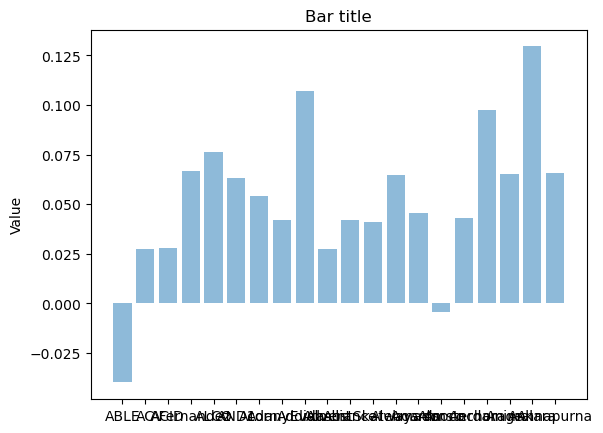

In [16]:
path="D:/Downloads/datasets/mini_logo_good/test1/11/50jpg.jpg"
img=Image.open(path)
tensorImg=transforms(img)
batchImg=torch.unsqueeze(tensorImg,0)
out=net(batchImg)
print(out)
test=out
out=out.squeeze()
out=out.tolist()
print(out)
print(max(out))
print(out.index(max(out)))
print(logos_list[out.index(max(out))])
print(sum(out))
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, out, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()
# dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
# #print(dataset[0])
# testloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)
# for sample in testloader:
#   img,label = sample
#   img=img.to(device)
#   pred=net(img)
  
#   pred=max(pred).tolist()
#   print(pred)
#   print(pred.index(max(pred)))
#   print(max(pred))
#   print(logos_list[ pred.index(max(pred))])

test for test dataset dataset img =1460

In [17]:
a=np.zeros(20)
path = 'D:/Downloads/datasets/mini_logo_good/train'
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True,num_workers=4)
loss_val=0
acc_val=0
for sample in dataloader:
    img,label = sample

    label = label.to(device)
    label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
    img = img.to(device) 
    pred = net (img)
    out=pred.squeeze()
    out=out.tolist()
    a[out.index(max(out))]+=1
    loss = loss_fn(pred, label)
         
    loss_val+=loss.item()
    acc_val += get_accuracy(pred.cpu(), label.cpu())
    
loss_val /= len(dataloader)
acc_val /= len(dataloader)
print("loss=",loss_val ,"accruracy=",acc_val)
print(a)
print(sum(a))

loss= 0.048185302737418556 accruracy= 0.06237148732008225
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0. 1459.    0.]
1459.0


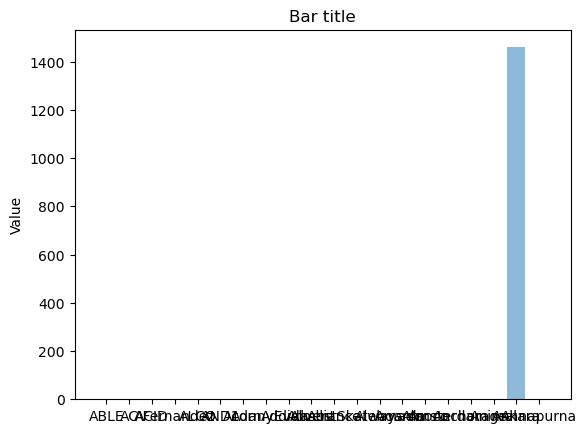

In [18]:
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, a, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()

эта хуйня не работает